# Amazon Reviews Dataset (2018) Analysis

The goal of this notebook is to quickly get an understanding of the [Amazon reviews dataset](https://jmcauley.ucsd.edu/data/amazon/). As the number of reviews per category can easily reach tens of millions, we aim at understanding the distribution of reviews and ratings in the dataset in order to implement a good strategy to build 3 datasets of reviews: a `train` set, `valid` set, and `test` set. We want the `train` dataset to have about 800 reviews per category and each review only have either a `Positive` sentiment or `Negative` sentiment. Both `valid` and `test` datasets would contain around 200 reviews each and only consider `Neutral` reviews. For each dataset, we aim at having 10 to 15 reviews per products where there is an uniform distribution of rating scores.

## Dataset description

This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014. For the task of text summarization, we will only use product reviews data. This dataset contains informations related to each reviews within the following 12 columns:
* **reviewerID**: ID of the reviewer, e.g. A2SUAM1J3GNN3B
* **asin**: ID of the product, e.g. 0000013714
* **reviewerName**: name of the reviewer
* **helpful**: helpfulness rating of the review, e.g. 2/3
* **reviewText**: text of the review
* **overall**: rating of the product
* **summary**: summary of the review
* **unixReviewTime**: time of the review (unix time)
* **reviewTime**: time of the review (raw)
* **vote**: helpfulness votes
* **verified**: review status
* **style**

## Analysis Summary

For this quick analysis of the Amazon reviews dataset, we only downloaded data from 7 (out of 29) of all categories. The sample dataset contains 3,025,691 reviews from 285,381 different products. The goal of this analysis was to implement a strategy to extract a sample of around 1,000 reviews for each category of products contained in the full Amazon reviews dataset whilst ensuring a uniform distribution over ratings for each product. Some of our findings are summarized can be follows:
* Considering the task of text summarization, some attributes of the Amazon reviews dataset are not very useful. For this task, we are more fucused on textual data (i.e. the reviews). Therefore, we only consider the columns `overall` (rating),  `asin` (product ID), `reviewText` (review text). The columns `reviewerID` and `reviewTime` would be useful to sort and remove duplicated reviews from the final dataset.

* About 97% of all reviews contained in this sample dataset have a length of between 1 and 200 words. Our analysis showed that reviews having less than 8 words are less precise and do not contain much useful information. Because of this, we filter out reviews having less than 8 words or more than 200 words.

* Our analysis also showed that, after filtering out reviews based on length, 97% of products have between 1 and 56 reviews while around 10% have at least 10 reviews. Given that we want a uniform distribution of ratings for each product, it would be appropriate to have at least 2 reviews per rating hence at least 10 reviews per product.

* Based on amazon.com labelling of the star system and the method used in the Yelp and IMDb datasets to infer sentiment from rating scores, the can map `Positive` reviews to the scores 4 and 5, `Neutral` reviews to the score 3, and `Negative` reviews to the scores 1 and 2.

Our extraction program will, therefore, consist of 3 filtering stages: (1) filter out reviews having a length outside the bounds of 8-200 words, (2) filter out products having less than 10 reviews, and (3) if building the training set, discard neutral reviews and keep them for the valid/test datasets.

## Download data

In [1]:
import gzip
import requests
import io
import json

import pandas as pd
import numpy as np
import datetime

import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time

In [3]:
sns.set()
%matplotlib inline

In [4]:
def get_gzipped_json(category, save=False):
    category = "_".join(category.split(" "))
    url = f"http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/{category}.json.gz" 
    print('Downloading Amazon reviews from: {}'.format(url))
    # Download and unzip file
    decompressed = gzip.decompress(requests.get(url).content)
    
    df = dict()
    with io.StringIO(decompressed.decode()) as file:
        for i,line in enumerate(file):
            df[i] = json.loads(line.strip())
        df = pd.DataFrame.from_dict(df, orient='index')
    
    # Add category column
    df["category"] = re.sub("\_", " ", category)
    
    if save:
        df.to_csv(f"./{category.lower()}.csv", index=False)
    
    return df

In [5]:
def download_and_combine(categories):
    dataset = None
    for cat in categories:
        df = get_gzipped_json(cat)
        if dataset is None:
            dataset = df
        else:
            dataset = pd.concat([dataset, df])
    
    return dataset

For this short analysis, we only retrieve a few categories having the smallest number of reviews.

In [6]:
categories = ["All Beauty", "Gift Cards", "Magazine Subscriptions", "Software", "Appliances", "AMAZON FASHION", "Prime Pantry"]

In [7]:
raw_df = download_and_combine(categories)

## Preleminary Analysis

In [8]:
print(f"Our sample dataset contains {raw_df.shape[0]} reviews of products from {len(categories)} different categories")

Our sample dataset contains 3025691 reviews of products from 7 different categories


In [9]:
raw_df.head(10)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,category
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN,All Beauty
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN,All Beauty
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN,All Beauty
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN,All Beauty
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN,All Beauty
5,5.0,False,"02 26, 2010",A36NF437WZLQ9E,0143026860,W. Powell,Today I gave a book about the Negro Leagues of...,The Gift of Black Baseball,1267142400,4,NaN,NaN,All Beauty
6,4.0,False,"03 7, 2001",A10Q8NIFOVOHFV,0143026860,Robert S. Clay Jr.,The story of race relations in American histor...,"Baseball, America, and racism.",983923200,14,NaN,NaN,All Beauty
7,1.0,True,"04 10, 2017",A26PO1B2Q2G1CS,014789302X,Jacqueline Diaz,I didn't like this product it smudged all unde...,One Star,1491782400,NaN,NaN,NaN,All Beauty
8,5.0,True,"01 3, 2017",AQ812VYVTC2RJ,014789302X,Khadijah Ali-Evans,I simply love the product. I appreciate print ...,Five Stars,1483401600,NaN,NaN,NaN,All Beauty
9,1.0,True,"11 19, 2016",AMACNEW14ADMX,014789302X,rabiyaa123,it burns your eyes when u put it on and very ...,i do not recommend.,1479513600,3,NaN,NaN,All Beauty


In [10]:
raw_df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          211
reviewText           2595
summary              1123
unixReviewTime          0
vote              2628617
style             2122084
image             2973618
category                0
dtype: int64

### Remove obsolete columns

The dataset we are building is aimed at the task of text summarization. Because of this, some of the columns included would not be of much use and we can also identify redundant attributes such as `unixReviewTime`.

In [11]:
raw_df = raw_df.drop(columns=["reviewerName", "unixReviewTime", "image"])

### Remove rows with missing review texts
Before proceeding to an exploration of each attribute of the dataset, we remove all rows with missing `reviewText` as they would be useless.

In [12]:
raw_df = raw_df[~raw_df["reviewText"].isna()]

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
df = raw_df.copy()

### category

In [15]:
# Show number of reviews per category
df["category"].value_counts()

AMAZON FASHION            882403
Appliances                602453
Prime Pantry              471233
Software                  459370
All Beauty                370946
Gift Cards                147035
Magazine Subscriptions     89656
Name: category, dtype: int64

### verified

In [16]:
round(100 * df["verified"].value_counts() / df.shape[0], 2)

True     86.06
False    13.94
Name: verified, dtype: float64

### reviewerID

In [17]:
print(f"There is a total of {df['reviewerID'].unique().shape[0]} unique reviewers.")

There is a total of 2195065 unique reviewers.


### vote

In [18]:
print(f'%{(100 * raw_df["vote"].isna().sum() / raw_df.shape[0]):.2f} of reviews do not have an helpfulness score')

%86.88 of reviews do not have an helpfulness score


### style

In [19]:
df["style"] = df["style"].astype(str)
df["style"].unique().tolist()[:20]

['nan',
 "{'Format:': ' Hardcover'}",
 "{'Size:': ' 44 oz'}",
 "{'Size:': ' 300'}",
 "{'Size:': ' 3 pack'}",
 "{'Size:': ' 3'}",
 "{'Size:': ' 45 Oz'}",
 "{'Size:': ' Color48'}",
 "{'Size:': ' 6.25 Inches'}",
 "{'Size:': ' Color42'}",
 "{'Size:': ' 86-pc'}",
 "{'Size:': ' 19 Peice'}",
 "{'Size:': ' Penta'}",
 "{'Size:': ' Color46'}",
 "{'Size:': ' Ikat Sphere Pear'}",
 "{'Size:': ' 3 Years'}",
 "{'Size:': ' Color47'}",
 "{'Size:': ' 3500'}",
 "{'Size:': ' 98 Feet'}",
 "{'Size:': ' Large, Vintage Black'}"]

### summary

The column `summary` does not appear to be a summary of all reviews associated with a given product. Therefore, it cannot be used as reference summary in the text summarization task. Moreover, we can also notice that `summary` contains relatively useless texts such as `!!!!`, `:)`, `$$$`, `5 star`, etc.

In [22]:
summaries = df["summary"].unique().tolist()
summaries[:30]

['One Star',
 "... to reading about the Negro Baseball and this a great addition to his library Our library doesn't haveinformation so ...",
 'Worth the Read',
 'Good Read',
 'More than facts, a good story read!',
 'The Gift of Black Baseball',
 'Baseball, America, and racism.',
 'Five Stars',
 'i do not recommend.',
 'Two Stars',
 'Nice quality, love the compact packaging',
 'Gorgeous!',
 'Mesmerizing Illustrations',
 'Inspiring',
 'A must have for any art fanatics',
 'Waited so long.',
 'cute!',
 'Fun twist to the old favorite, Bingo.',
 'ADORABLE Cards!',
 'Send a smile to someone you love!',
 'HUUUUGE!',
 'Thomas Kinkade Angel of Glory Illuminated figurine',
 'This is the perfect tick removal tool.',
 'Akatsuki Pride',
 'Great product',
 'Wonderful stand for my brush and razor',
 'But I bent it just a little and it fits fine now.',
 'good fit and finish',
 'Excellent',
 'Very wobbly stand...']

### reviewText

In [23]:
def filter_reviews(text):
    # If the text does not contain any alphanumeric character, then return blank
    # This should get rid of reviews such as "!!!!!", ":)", "~~", etc.
    if not re.search("[a-zA-Z]+", text):
        return None
    return text

In [24]:
def get_lengths(text):
    return len(text.split())

In [25]:
# Remove text having no alphanumeric characters
df["reviewText"] = df["reviewText"].apply(filter_reviews)

Add information about the length of reviews texts

In [26]:
# Add sequence lengths
df["review_len"] = df["reviewText"].apply(lambda x: len(str(x).split()))

In [27]:
df["review_len"].describe().apply(lambda x: format(x, 'f'))

count    3023096.000000
mean          37.941292
std           68.823854
min            1.000000
25%            7.000000
50%           19.000000
75%           41.000000
max         5118.000000
Name: review_len, dtype: object

#### Analysis of review lengths

In [28]:
review_lengths = df["review_len"].values

As the distribution of the review lengths is difficult to see with the original data, we apply a log function to the data in order to make it clearer.

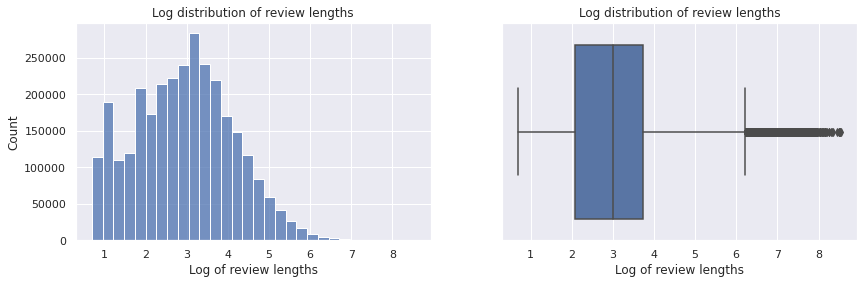

In [29]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2, nrows=1)
axes[0].set_title("Log distribution of review lengths")
axes[0].set_xlabel("Log of review lengths")
axes[1].set_title("Log distribution of review lengths")
axes[1].set_xlabel("Log of review lengths")
sns.histplot(x=np.log(1 + review_lengths), bins=30, ax=axes[0])
sns.boxplot(x=np.log(1 + review_lengths), ax=axes[1])
plt.show()

In [30]:
# Compute confidence interval
conf_interval = pd.Series(review_lengths).quantile([0.025, 0.975]).values.tolist()
conf_interval

[1.0, 201.0]

In [31]:
print(f'%{(100 * df[(df["review_len"] >= conf_interval[0]) & (df["review_len"] <= conf_interval[1])].shape[0] / df.shape[0]):.2f} '
      + f'of reviews have between {conf_interval[0]} and {conf_interval[1]} words')

print(f'%{(100 * df[(df["review_len"] >= conf_interval[0]) & (df["review_len"] < 8)].shape[0] / df.shape[0]):.2f} '
      + f'of reviews have between {conf_interval[0]} and {8} words')

print(f'%{(100 * df[(df["review_len"] >= 8) & (df["review_len"] <= conf_interval[1])].shape[0] / df.shape[0]):.2f} '
      + f'({df[(df["review_len"] >= 8) & (df["review_len"] <= conf_interval[1])].shape[0]}) '
      + f'of reviews have between {8} and {conf_interval[1]} words')

print(f'%{(100 * df[(df["review_len"] >= 15) & (df["review_len"] <= conf_interval[1])].shape[0] / df.shape[0]):.2f} '
      + f'({df[(df["review_len"] >= 15) & (df["review_len"] <= conf_interval[1])].shape[0]}) '
      + f'of reviews have between {15} and {conf_interval[1]} words')

print(f'%{(100 * df[(df["review_len"] >= 75) & (df["review_len"] <= conf_interval[1])].shape[0] / df.shape[0]):.2f} '
      + f'({df[(df["review_len"] >= 75) & (df["review_len"] <= conf_interval[1])].shape[0]}) '
      + f'of reviews have between {75} and {conf_interval[1]} words')

print(f'%{(100 * df[(df["review_len"] > conf_interval[1])].shape[0] / df.shape[0]):.2f} '
      + f'of reviews have more than {conf_interval[1]} words')

%97.52 of reviews have between 1.0 and 201.0 words
%27.54 of reviews have between 1.0 and 8 words
%69.98 (2115540) of reviews have between 8 and 201.0 words
%54.45 (1646100) of reviews have between 15 and 201.0 words
%10.03 (303353) of reviews have between 75 and 201.0 words
%2.48 of reviews have more than 201.0 words


The majority of reviews have a length of between 1 and 201 words. However, as shown below, reviews having fewer words are less precise and can be quite generic.

In [32]:
df.loc[df["review_len"] == 1, "reviewText"].tail(8).values.tolist()

['Great', 'Delicious!', 'great', 'yum', 'good', 'great', 'Yum!', 'Yum!']

In [33]:
df.loc[df["review_len"] == 3, "reviewText"].tail(8).values.tolist()

['My favorite item',
 'Kids love this',
 'Really great stuff.',
 'Love this cereal!',
 'Exactly as described!',
 'These are delicious!',
 'They are yummy!',
 'Oh so good.']

In [34]:
df.loc[df["review_len"] == 5, "reviewText"].tail(8).values.tolist()

['Great product. Thank you :)',
 'Love love love this cereal!',
 'good product but over priced',
 "Eh. Didn't taste that good.",
 'I love these very much',
 'husband likes these very well',
 'Love the combo of flavors',
 'Great.  Ordered 4 more boxes.']

At 6 words, the reviews start showing more information about specific aspects of the product but still a bit generic.

In [35]:
df.loc[df["review_len"] == 6, "reviewText"].tail(15).values.tolist()

['THESAME WITH THIS HVE TO TRY',
 'Healthy tasty cracker great with hummus',
 'pretty good for a diet snack',
 'My kiddo thought they were Oreos....WTF??',
 'everyone in the family likes them',
 'They kids love them great snacks',
 'Meh, not as good as original',
 'Simply delicious!  Crispy, bite sized goodies!',
 'These are just the best crackers.',
 'Just right size for lunch box.',
 'It taste good and shipped fast',
 'I love the kind of cookies.',
 'Perfect for hospital snack after delivery.',
 "These are so good. I'm addicted",
 'Great taste but smaller than expected.']

At 7 words, the review are more specific and provide useful information about certain aspects of the product.

In [36]:
df.loc[df["review_len"] == 7, "reviewText"].tail(15).values.tolist()

['perfect size for diabetics supplies and medication',
 'Alright, but they are not that sharp',
 'Very happy with the purchase. Good quality.',
 'Not what I expected.  They are good.',
 'Arrived stale and went into the trash.',
 'grand-kids say thank you. they loved them.',
 'Hear are one of my favorite snacks.',
 'They are ok. The kiddos like them.',
 'One of my favorite, buttery flavored crackers',
 "I like the added m and m's.",
 'They were totally hard.  What a disappointment.',
 'Exactly as described. Fresh.  Arrived on time.',
 'Tasty!\nNice flavor.  Goes great with hummus.',
 'Not tasty at all, and definitely over-priced',
 'perfect tasty pick-up for breakfast or snack']

However, at 8 words, we can observe that the reviews are written in full sentences and not just a list of words.

In [37]:
df.loc[df["review_len"] == 8, "reviewText"].tail(15).values.tolist()

['they are smaller than they use to be',
 'Good taste and flavor. I will buy again.',
 'Wrong ones thought they were the chip version.',
 'Got these for my husband.  He loves them.',
 'I think everyone knows how these taste? Yummy',
 'the children loved them, they where also fresh',
 "Wasn't quite the flavor that I was expecting.",
 'Great Value, 16 for the price of 8',
 'Best tasty small crackers, but a bit expensive.',
 'G O N E - kids loved them',
 'good for you. Has a good taste Soft',
 'I really enjoyed the taste of these bars.',
 'I love kind bars they are great snacks.',
 'it goes along with the other kind bars',
 'How can you beat it...chocolate and nuts, yum.']

In [38]:
df.loc[df["review_len"] == 20, "reviewText"].tail(15).values.tolist()

["My Malti Poo Puppy  loves this so much I have to pick up his dish or he won't stop eating!",
 'My doxie loves these.  I cut them into smaller strips for her so she can have a treat every night.',
 'Neither of my two cats like this food. I feel like it is marketed for humans not for the cats.',
 'my dogs love, but they literally bite them through and swallow whole like a hungry person does a snickers bar',
 'My dog would not eat this food at all. Even mixed with other, more enticing brands she picks around this.',
 'Great product to keep personal or office records. A+++. Will buy more soon in future. Product description as is. Nice',
 'Push pins are needed for any office.  Comes in a nice plastic container.  They work!  What more can you say.',
 'The cookies themselves were great and the price was amazing so I bought 2 but they were received mostly broken.',
 "They didn't taste as good as they sounded, I love apple filling, but these did not really appeal to me.",
 "I love these crack

In [39]:
df.loc[df["review_len"] == 200, "reviewText"].tail(3).values.tolist()

['The combination of honey Dijon mustard and almonds was something I could not envision so out of curiosity I ordered a can. Somehow it works  I think because rather than just adding a strong mustard flavor to the nuts, a more subtle concoction of seasonings was created that while distinct, is not overpowering. So, the almond flavor is still present, just simply seasoned with a mix that alludes to honey Dijon rather than screams it.\n\nI often eat almonds as a snack because, unlike chips and most crackers, there is at least some nutritional value involved. A one ounce 170 calorie serving size is 28 nuts and often half that quantity is a satisfying amount. Each serving has 15 grams of fat (1 saturated), 2 grams of sugar, 3 grams fiber, 6 grams protein and 115 mg sodium.\n\nA little sweet and a little salty, but not too much of either, this variety pairs well with sharp cheese, fruit and cold drinks. A simple apple and a few nuts made for an excellent snack. The best before date on the c

#### Filtering reviews and products

Our analysis suggests that the more words used, the more information is found in the review. The reviews are written in more complete sentences and are related to a specific aspect of a product. As the goal of a text summarization is to produce a short but very informative summary of multiple document, we need a lot of useful information from the reviews. On the other, a very few percentage (%2.5) of reviews have more than 200 words. Although longer reviews may contain more information, a too large review can also introduce redundant information or noise. 

It is to be noted that the data used in this notebook is only a small subset of the full Amazon reviews datatset (2018). The [Amazon Reviews Guidelines](https://www.amazon.ca/gp/help/customer/display.html?nodeId=201929830) suggests a good review to have between 75 and 500 words. As our analysis indicates that there are very few reviews longer than 200 words, we can set the upper limit to 200.

In [40]:
# Extract number of reviews per product where each review has at least 8 words
reviews_len_counts = df.loc[df["review_len"] >= 8, ["asin", "category", "reviewText"]]\
                        .groupby(["category", "asin"], as_index=False).agg("count")\
                        .rename(columns={"reviewText": "counts"})

In [41]:
reviews_len_counts["counts"].describe()

count    241546.000000
mean          9.069126
std          63.862305
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        7780.000000
Name: counts, dtype: float64

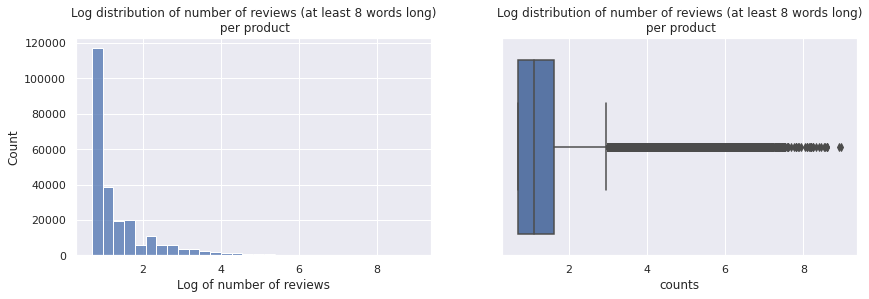

[1.0, 56.0]

In [42]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2, nrows=1)
axes[0].set_title("Log distribution of number of reviews (at least 8 words long)\n per product")
axes[0].set_xlabel("Log of number of reviews")
axes[1].set_title("Log distribution of number of reviews (at least 8 words long)\n per product")
axes[1].set_xlabel("Log of number of reviews")
sns.histplot(x=np.log(1 + reviews_len_counts["counts"]), bins=30, ax=axes[0])
sns.boxplot(x=np.log(1 + reviews_len_counts["counts"]), ax=axes[1])
plt.show()

# Compute confidence interval
conf_interval = pd.Series(reviews_len_counts["counts"]).quantile([0.025, 0.975]).values.tolist()
conf_interval

In [43]:
print(f'%{(100 * reviews_len_counts[(reviews_len_counts["counts"] >= conf_interval[0]) & (reviews_len_counts["counts"] <= conf_interval[1])].shape[0] / reviews_len_counts.shape[0]):.2f} '
      + f'of products have between {conf_interval[0]} and {conf_interval[1]} reviews')

print(f'%{(100 * reviews_len_counts[(reviews_len_counts["counts"] >= 6) & (reviews_len_counts["counts"] <= conf_interval[1])].shape[0] / reviews_len_counts.shape[0]):.2f} '
      + f'({reviews_len_counts[(reviews_len_counts["counts"] >= 6) & (reviews_len_counts["counts"] <= conf_interval[1])].shape[0]}) '
      + f'of products have between {6} and {conf_interval[1]} reviews')

print(f'%{(100 * reviews_len_counts[(reviews_len_counts["counts"] >= 10) & (reviews_len_counts["counts"] <= conf_interval[1])].shape[0] / reviews_len_counts.shape[0]):.2f} '
      + f'({reviews_len_counts[(reviews_len_counts["counts"] >= 10) & (reviews_len_counts["counts"] <= conf_interval[1])].shape[0]}) '
      + f'of products have between {10} and {conf_interval[1]} reviews')

%97.53 of products have between 1.0 and 56.0 reviews
%16.88 (40783) of products have between 6 and 56.0 reviews
%10.05 (24286) of products have between 10 and 56.0 reviews


In [44]:
reviews_len_counts.loc[(reviews_len_counts["counts"] >= 10) & (reviews_len_counts["counts"] <= 56), ["category", "asin"]].groupby("category", as_index=False).agg("count").rename(columns={"asin": "num_products"})

,category,num_products
0,AMAZON FASHION,8396
1,All Beauty,3086
2,Appliances,3990
3,Gift Cards,487
4,Magazine Subscriptions,644
5,Prime Pantry,4294
6,Software,3389


After filtering out reviews having less than 8 words or more than 200 words, we are left with. Considering that our goal is to have about 1,000 reviews per category and a uniform distribution of ratings for each product, we need to extract a maximum number of reviews for each product. Our analysis shows that around 10% of products have at least 10 reviews--which corresponds to 24,286 products. Moreover, looking at each category, we can observe that the category with the smallest number of products has 487 products in total. 

With at least 10 reviews per product, this number is more than enough to reach our goal. Therefore, we can filter out all products having less than 10 reviews as well as all reviews having less than 8 words or more than 200 words.

In [45]:
df.shape[0]

3023096

In [46]:
# Filter based on review lengths
df = df[(df["review_len"] >= 8) & (df["review_len"] <= 200)]
df = df.reset_index(drop=True)
df.shape[0]

2114802

### overall (ratings)

In [47]:
df["overall"].describe().apply(lambda x: format(x, 'f'))

count    2114802.000000
mean           3.935254
std            1.456964
min            1.000000
25%            3.000000
50%            5.000000
75%            5.000000
max            5.000000
Name: overall, dtype: object

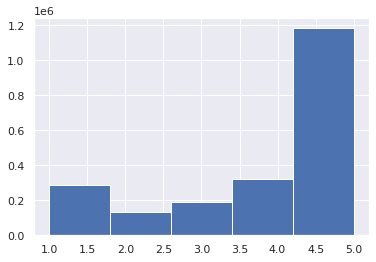

In [48]:
df["overall"].hist(bins=5)
plt.show()

In [49]:
df[["overall", "reviewText"]].groupby("overall", as_index=False).agg("count").rename(columns={"reviewText": "counts"})

,overall,counts
0,1.0,287857
1,2.0,133275
2,3.0,190519
3,4.0,319435
4,5.0,1183716


### polarity (review sentiment)

We take some inspiration from the [Yelp](https://proceedings.neurips.cc/paper/2015/file/250cf8b51c773f3f8dc8b4be867a9a02-Paper.pdf) and [IMDb](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) datasets to create a sentiment column. Both of these datatsets map a certain interval of rating scores to a given sentiment. For instance, [IMDb](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) considers a review to be potitive if its score is $>=7$ and negative if it is $<=4$ on a scale of $1$ to $10$. Similarily, based on the paper, [Yelp](https://proceedings.neurips.cc/paper/2015/file/250cf8b51c773f3f8dc8b4be867a9a02-Paper.pdf) uses a scale of $1$ to $4$ where scores $1$ and $2$ are associated with negative sentiment and $3$ and $4$ are positive. If we scale the scores to $[0.0, 1.0]$, this would be $[0.0, 0.33]$ (`Positive`) and $[0.67, 1.0]$ (`Negative`). Furthermore, we can notice by using Amazon.com that the different stars numbers are labeled on the website:
* 1 stars: Very bad
* 2 stars: Bad
* 3 stars: Okay
* 4 stars: Good
* 5 stars: Very Good

Based on this information, we can safely discard reviews with 3 stars (neutral) and map ratings scores $1$ to $2$ to `Negative` sentiment and $4$ and $5$ to `Positive` sentiment.

In [53]:
MAX_RATING = 5.0
MIN_RATING = 1.0

def infer_sentiment(rating):
    MIN_POSITIVE = 0.67
    MAX_NEGATIVE = 0.33
    # Scale rating
    rating = (float(rating) - MIN_RATING) / (MAX_RATING - MIN_RATING)
    
    sentiment = "neutral"
    
    if rating <= MAX_NEGATIVE:
        sentiment = "negative"
    elif rating >= MIN_POSITIVE:
        sentiment = "positive"
        
    return sentiment

In [54]:
df["polarity"] = df["overall"].apply(infer_sentiment)

In [55]:
df.head(10)

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,vote,style,category,review_len,polarity
0,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,NaN,nan,All Beauty,29,positive
1,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,"This book was very informative, covering all a...",Worth the Read,NaN,nan,All Beauty,10,positive
2,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,I am already a baseball fan and knew a bit abo...,Good Read,NaN,nan,All Beauty,23,positive
3,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",5,nan,All Beauty,67,positive
4,1.0,True,"04 10, 2017",A26PO1B2Q2G1CS,014789302X,I didn't like this product it smudged all unde...,One Star,NaN,nan,All Beauty,14,negative
5,5.0,True,"01 3, 2017",AQ812VYVTC2RJ,014789302X,I simply love the product. I appreciate print ...,Five Stars,NaN,nan,All Beauty,13,positive
6,1.0,True,"11 19, 2016",AMACNEW14ADMX,014789302X,it burns your eyes when u put it on and very ...,i do not recommend.,3,nan,All Beauty,36,negative
7,2.0,True,"11 10, 2016",A5FS4FVWR77O6,014789302X,"smaller versions, not full size as shown in pics",Two Stars,NaN,nan,All Beauty,9,negative
8,4.0,True,"08 5, 2016",A3CKVF2ZR1CBO0,014789302X,purchased for vending resale at bellydance wee...,"Nice quality, love the compact packaging",5,nan,All Beauty,26,positive
9,5.0,True,"07 29, 2016",A3IFT6SR16SAYU,014789302X,I love it and it arrived on time,Five Stars,NaN,nan,All Beauty,8,positive


<AxesSubplot:>

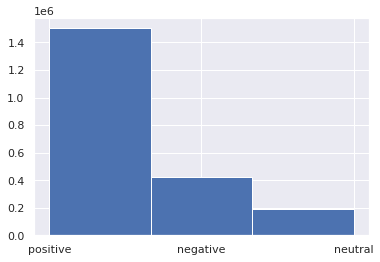

In [56]:
df["polarity"].hist(bins=3)

### asin (product ID)

In [57]:
print(f"There is a total of {df['asin'].unique().shape[0]} unique products after filtering.")

There is a total of 239538 unique products after filtering.


Number of products for each category

In [58]:
for cat in df["category"].unique():
    print(f"{cat}: {df.loc[df['category'] == cat, 'asin'].unique().shape[0]}")

All Beauty: 27873
Gift Cards: 1472
Magazine Subscriptions: 2288
Software: 20008
Appliances: 24934
AMAZON FASHION: 152571
Prime Pantry: 10392


Number of reviews per products

In [59]:
df["asin"].value_counts().describe()

count    239538.000000
mean          8.828670
std          61.988925
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        7388.000000
Name: asin, dtype: float64